## MiDaS for Depth Estimation
Computing relative inverse depth from a **single image**.
For using Large or Hybrid models it is recommended that using GPU.

- Reference: https://github.com/isl-org/MiDaS

### Dependency

In [1]:
# pip install timm

### Imports

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

### Download a Sample Image

In [3]:
url = "https://herthundbuss.com/wp-content/uploads/2022/01/Zwangspause-im-Stau-HerthBuss.jpg"
filepath = "./images/traffic.jpg"
urllib.request.urlretrieve(url, filepath)

('./images/traffic.jpg', <http.client.HTTPMessage at 0x7f9e645d0a60>)

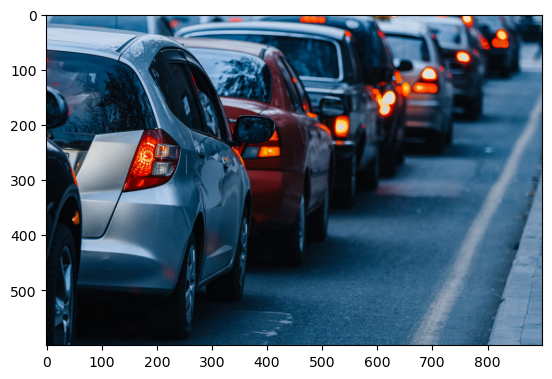

In [20]:
original_image = cv2.imread("./images/traffic.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)

### Load Model

In [13]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

### Check GPU Availability to Move Model

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

### Load Transforms 
To resize and normalize the frame for large or small model

In [16]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

### Load Image and Apply Transforms

In [10]:
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

### Prediction, and Resize to the Origin Resolution
Explanation of Parameters:

`size=img.shape[:2]` --> (height, width) of the original image

`mode="bicubic"` --> A method of resampling that can produce smoother image

`prediction.unsqueeze(1)` --> increasing the dimensionality of the prediction tensor to make it compatible with the interpolate function, which expects a 4D tensor (batch size, channels, height, width).

`.squeeze()` --> Removes the extra dimension added by unsqueeze, returning the tensor to its original shape, but now at the new size.

`output = prediction.cpu().numpy()` --> Moves the prediction from the GPU (if it's being used) back to the CPU's memory. Then, converts the Pytorch tensor to Numpy array(To save on a disk or use with other libraries).

In [11]:
# For Prediction there is no need to Keep track of Gradiants
# It also helps for saving memory and computations
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

### Show the Result

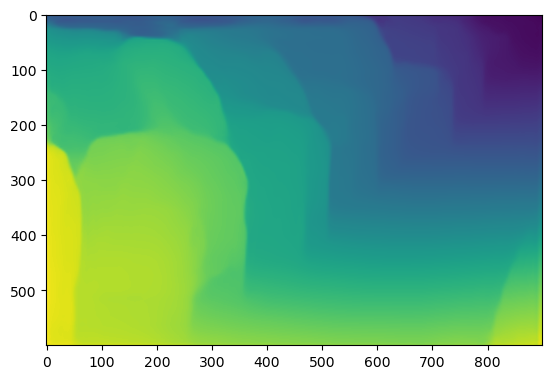

In [12]:
plt.imshow(output)